In [1]:
import pandas as pd
import re

In [2]:
tsla = pd.read_csv('TSLA(2).csv')
elon = pd.read_csv('elonmusk.csv')

In [3]:
def separate_date(x):
    timestamp = pd.Timestamp(x)
    date = timestamp.date()
    time = timestamp.time()
    
    return date


def separate_time(x):
    timestamp = pd.Timestamp(x)
    date = timestamp.date()
    time = timestamp.time()

    return time


In [4]:
tsla['Date'] = tsla['Date'].apply(lambda x: pd.Timestamp(x).date())
elon['Date'] = elon.apply(lambda x: separate_date(x['Timestamp']), axis=1)
elon['Time'] = elon.apply(lambda x: separate_time(x['Timestamp']), axis=1)
elon['weekday'] = elon['Date'].apply(lambda x: x.weekday())
elon['is_weekend'] = elon['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
elon['trading_day'] = 0
elon.loc[elon['Date'].isin(tsla['Date']), ['trading_day']] = 1


In [5]:
tsla['Open'].describe()

count    2976.000000
mean      144.787077
std       260.019507
min         3.228000
25%        20.340000
50%        46.893999
75%        68.468502
max      1234.410034
Name: Open, dtype: float64

In [6]:
tsla['Close'].describe()

count    2976.000000
mean      144.824658
std       259.981333
min         3.160000
25%        20.256000
50%        46.824999
75%        68.574499
max      1229.910034
Name: Close, dtype: float64

In [7]:
tsla['Delta'] = tsla['Close'] / tsla['Open'] - 1
tsla['min_max_ratio'] = tsla['High'] / tsla['Low'] - 1

In [8]:
tsla[tsla['min_max_ratio'] <0]

,Date,Open,High,Low,Close,Adj Close,Volume,Delta,min_max_ratio


In [9]:
tsla[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', ]] = tsla[[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',]].pct_change(fill_method='ffill')
    

In [10]:
tsla['Delta'].describe()

count    2976.000000
mean        0.000383
std         0.029296
min        -0.197535
25%        -0.014842
50%        -0.000110
75%         0.015624
max         0.257368
Name: Delta, dtype: float64

In [11]:
def getFivePriorTradingDays(date):
    priors = tsla[tsla['Date'] < date]
    return priors['Date'].tail(5).tolist()
    
    

In [12]:
def getValues(dates, col):
    res = []
    for date in dates:
        res.append(tsla[tsla['Date'] == date][col].values[0])
    
    return res

In [13]:
elon['five_prior_trading_days'] = elon['Date'].apply(lambda x: getFivePriorTradingDays(x))

In [14]:
elon['five_prior_close'] = elon.apply(lambda x: getValues(x['five_prior_trading_days'], 'Close'), axis=1)
elon['five_prior_open'] = elon.apply(lambda x: getValues(x['five_prior_trading_days'], 'Open'), axis=1)
elon['five_prior_delta'] = elon.apply(lambda x: getValues(x['five_prior_trading_days'], 'Delta'), axis=1)
elon['five_prior_ratio'] = elon.apply(lambda x: getValues(x['five_prior_trading_days'], 'min_max_ratio'), axis=1)



In [15]:
usefulElon = elon[['text','Comments','Likes','Retweets','Date', 'Time','weekday', 'is_weekend', 'five_prior_trading_days','five_prior_open','five_prior_close','five_prior_delta','five_prior_ratio', 'trading_day']].loc[1:]

In [16]:
def clean_text(x):
    temp = x.lower()
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    temp = re.sub(r"\n", " ", temp)
    temp = temp.rsplit(' ', 3)[0]
    return temp
    
    
    

In [17]:
usefulElon['clean_text'] = usefulElon['text'].apply(lambda x: clean_text(x))

In [18]:
def get_trading_info(row):
    if row['trading_day'] == 1:
        temp = tsla[tsla['Date'] == row['Date']]
    else:
        next_trading_day = tsla[tsla['Date'] > row['Date']].iloc[0]['Date']
        temp = tsla[tsla['Date'] == next_trading_day]
    
    return pd.Series(temp.values[0][1:])

In [19]:
labels = usefulElon.copy()
labels[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Delta','min_max_ratio']] = labels.apply(
    lambda x: get_trading_info(x), axis=1)


In [20]:
labels = labels[['Date','Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Delta','min_max_ratio']]

In [21]:
usefulElon.fillna(0, inplace=True)

In [22]:
labels.describe()

,Open,High,Low,Close,Adj Close,Volume,Delta,min_max_ratio
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,0.004407,0.007417,0.005107,0.007914,0.007914,0.114038,0.003564,0.046063
std,0.039640,0.039457,0.035900,0.043564,0.043564,0.612199,0.032928,0.028780
min,-0.210924,-0.185493,-0.185904,-0.210628,-0.210628,-0.796381,-0.197535,0.008483
25%,-0.014350,-0.014078,-0.013960,-0.014672,-0.014672,-0.209621,-0.014102,0.027693
50%,0.003129,0.003530,0.005606,0.003654,0.003654,-0.002474,0.001552,0.038104
75%,0.022763,0.022985,0.022755,0.026674,0.026674,0.295200,0.019283,0.054357
max,0.219478,0.301890,0.187831,0.243951,0.243951,11.167515,0.157802,0.260950


<AxesSubplot:>

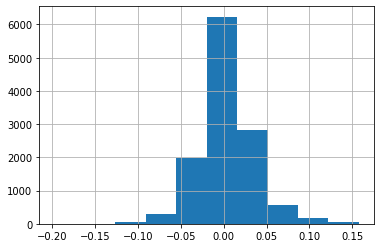

In [23]:
labels.Delta.hist()

<AxesSubplot:>

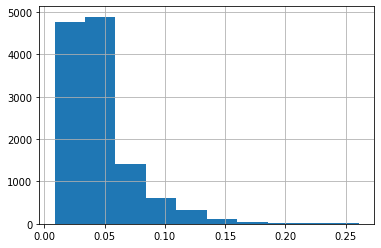

In [24]:
labels.min_max_ratio.hist()

In [25]:
labels.to_csv('lables.csv')
usefulElon.to_csv('features.csv')

In [26]:
labels = pd.read_csv('lables.csv', index_col=0)
features = pd.read_csv('features.csv',index_col=0)

In [27]:
labels

,Date,Open,High,Low,Close,Adj Close,Volume,Delta,min_max_ratio
1,2011-12-01,0.002154,0.032189,-0.007449,-0.004276,-0.004276,0.354991,0.000921,0.062852
2,2011-12-01,0.002154,0.032189,-0.007449,-0.004276,-0.004276,0.354991,0.000921,0.062852
3,2011-12-03,0.021322,0.038884,0.031790,0.033634,0.033634,0.445067,0.026543,0.046964
4,2011-12-03,0.021322,0.038884,0.031790,0.033634,0.033634,0.445067,0.026543,0.046964
5,2011-12-04,0.021322,0.038884,0.031790,0.033634,0.033634,0.445067,0.026543,0.046964
...,...,...,...,...,...,...,...,...,...
12201,2022-03-03,0.007614,-0.000045,-0.013823,-0.046142,-0.046142,-0.174426,-0.044926,0.064665
12202,2022-03-03,0.007614,-0.000045,-0.013823,-0.046142,-0.046142,-0.174426,-0.044926,0.064665
12203,2022-03-02,0.002817,-0.003821,-0.011139,0.017955,0.017955,-0.001653,0.008898,0.049996
12204,2022-03-04,-0.033763,-0.034734,-0.008936,-0.001191,-0.001191,0.087239,-0.012731,0.036950


In [28]:
features

,text,Comments,Likes,Retweets,Date,Time,weekday,is_weekend,five_prior_trading_days,five_prior_open,five_prior_close,five_prior_delta,five_prior_ratio,trading_day,clean_text
1,Went to Iceland on Sat to ride bumper cars on ...,30,24,188,2011-12-01,09:55:11,3,0,"[datetime.date(2011, 11, 23), datetime.date(20...","[0.0, -0.006612090680100824, 0.014263074484944...","[-0.019332709697536532, 0.006677265500794949, ...","[-0.009760705289672544, 0.0034865293185419866,...","[0.025600000000000067, 0.04279279279279269, 0....",1,went to iceland on sat to ride bumper cars on ...
2,I made the volume on the Model S http://ow.ly/...,29,17,78,2011-12-01,10:29:04,3,0,"[datetime.date(2011, 11, 23), datetime.date(20...","[0.0, -0.006612090680100824, 0.014263074484944...","[-0.019332709697536532, 0.006677265500794949, ...","[-0.009760705289672544, 0.0034865293185419866,...","[0.025600000000000067, 0.04279279279279269, 0....",1,i made the volume on the model s go to 11. n...
3,"Great Voltaire quote, arguably better than Twa...",23,30,44,2011-12-03,08:20:28,5,1,"[datetime.date(2011, 11, 28), datetime.date(20...","[0.014263074484944571, 0.015312500000000062, 0...","[0.028427037271004485, -0.02487714987714984, 0...","[0.01749999999999985, -0.022776238842720953, 0...","[0.04621188305564283, 0.04552639898830235, 0.0...",0,"great voltaire quote, arguably better than twa..."
4,That was a total non sequitur btw\n26\n14\n50,26,14,50,2011-12-03,08:22:07,5,1,"[datetime.date(2011, 11, 28), datetime.date(20...","[0.014263074484944571, 0.015312500000000062, 0...","[0.028427037271004485, -0.02487714987714984, 0...","[0.01749999999999985, -0.022776238842720953, 0...","[0.04621188305564283, 0.04552639898830235, 0.0...",0,that was a total non sequitur btw
5,Am reading a great biography of Ben Franklin b...,18,18,80,2011-12-04,03:33:52,6,1,"[datetime.date(2011, 11, 28), datetime.date(20...","[0.014263074484944571, 0.015312500000000062, 0...","[0.028427037271004485, -0.02487714987714984, 0...","[0.01749999999999985, -0.022776238842720953, 0...","[0.04621188305564283, 0.04552639898830235, 0.0...",0,am reading a great biography of ben franklin b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12201,Replying to \n@TheBabylonBee\n515\n464\n14.5K,515,464,14.5K,2022-03-03,04:25:03,3,0,"[datetime.date(2022, 2, 24), datetime.date(202...","[-0.15659354683255045, 0.1553990814674877, 0.0...","[0.04807345565365173, 0.011364030586459739, 0....","[0.14332015427147415, 0.00079089383218367, 0.0...","[0.1463999714285713, 0.04741816827960621, 0.07...",1,replying to @thebabylonbee
12202,Replying to \n@OwenSparks_\n @ICannot_Enough\n...,286,204,"4,003",2022-03-03,08:13:32,3,0,"[datetime.date(2022, 2, 24), datetime.date(202...","[-0.15659354683255045, 0.1553990814674877, 0.0...","[0.04807345565365173, 0.011364030586459739, 0....","[0.14332015427147415, 0.00079089383218367, 0.0...","[0.1463999714285713, 0.04741816827960621, 0.07...",1,replying to @owensparks_ @icannot_enough an...
12203,Replying to \n@DBurkland\nInvestigating\n350\n...,350,165,"5,133",2022-03-02,03:15:03,2,0,"[datetime.date(2022, 2, 23), datetime.date(202...","[-0.004435773773657781, -0.15659354683255045, ...","[-0.06997924478789808, 0.04807345565365173, 0....","[-0.07994655246032278, 0.14332015427147415, 0....","[0.09826968312367135, 0.1463999714285713, 0.04...",1,replying to @dburkland investigating
12204,Replying to \n@RenataKonkoly\n @MLUKBrandenbur...,233,185,"4,191",2022-03-04,21:40:29,4,0,"[datetime.date(2022, 2, 25), datetime.date(202...","[0.1553990814674877, 0.00714262958967482, 0.06...","[0.011364030586459739, 0.07477743140737036, -0...","[0.00079089383218367, 0.06799914396143425, -0....","[0.04741816827960621, 0.07628476552605856, 0.0...",1,replying to @renatakonkoly @mlukbrandenburg ...


In [29]:
features.five_prior_trading_days.iloc[0]

'[datetime.date(2011, 11, 23), datetime.date(2011, 11, 25), datetime.date(2011, 11, 28), datetime.date(2011, 11, 29), datetime.date(2011, 11, 30)]'